<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/shawnrhoads/gu-psyc-347/blob/master/docs/module-04-01_Prosocial-RL-Exercises.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# Prosocial RL Exercises

We will now fit your behavioral data to the models developed during class (as well as a few others) and then compare the models to assess which model best explains the data. This exercise is a bit different from previous exercises. I will only provide you with minimal code/text to guide you through, but you should be able to complete it all on your own using the course resources, previous tutorials/exercises, previous papers, and previous lectures!

**Once you complete this exercise, you will be well on your way to becoming a pro computational modeler!**

<hr width=50%>

You can download the data from [GitHub](https://github.com/shawnrhoads/gu-psyc-347/tree/master/docs/static/data) or by using the following code.

In [1]:
# import relevant modules
from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2021)                # set seed for reproducibility

In [2]:
# this function will load the data into memory 
def load_subjects():
    '''
    input: n/a
    output: dictionary of DataFrames containing the data
    '''
    urls = [f'https://raw.githubusercontent.com/shawnrhoads/gu-psyc-347/master/docs/static/data/{x:02}_psyc-347-prosocial-learning.csv' for x in range(1,12)]
        
    subject_data = {}
    for index, file in enumerate(urls):
        df = pd.read_csv(file, index_col='subject')
        subject_data[index] = df_filtered = df[df['outcomeDescr'] != 'practice'][['block',
                                                                                  'trial_num',
                                                                                  'true_accuracy',
                                                                                  'outcome',
                                                                                  'outcomeDescr',
                                                                                  'cumulativePts_self',
                                                                                  'cumulativePts_social']]
        
    return subject_data

In [3]:
# let's load in our data using the function above
subject_data = load_subjects()

## Relevant Data 

#### 4 conditions/blocks
- self, win
- self, avoid loss
- social, win
- social, avoid loss

#### Each block contains 24 trials
- 2 stimuli per trial (counterbalanced wrt side)
- outcomes associated with each stimulus is probabilistic (75%, 25%)

#### Data output key
- `block`: (play for self to win); (play for self to avoid loss); (play for next student to win); (play for next student to avoid loss)
- `trial_num`: order in which trials are displayed within a block (0-23)
- `true_accuracy`: 1 if selected stimulus with highest probability of winning or avoid losing
- `outcome`: outcome for trial (`+1`, `0`, `-1`); blank if missed
- `outcomeDescr`: text description of outcome (practice, social win, social avoid win, social loss, social avoid loss, self win, self avoid win, self loss, self avoid loss)
- `cumulativePts_self`: running total of points for self
- `cumulativePts_social`: running total of points for social

In [4]:
# display data from first subject
display(subject_data[0])

,block,trial_num,true_accuracy,outcome,outcomeDescr,cumulativePts_self,cumulativePts_social
subject,,,,,,,
1.0,social_win,0,0.0,0.0,social avoid win,1000,1000
1.0,social_win,1,1.0,1.0,social win,1000,1100
1.0,social_win,2,1.0,1.0,social win,1000,1200
1.0,social_win,3,1.0,1.0,social win,1000,1300
1.0,social_win,4,1.0,0.0,social avoid win,1000,1300
...,...,...,...,...,...,...,...
1.0,self_avoidloss,19,1.0,0.0,self avoid loss,2100,1300
1.0,self_avoidloss,20,1.0,0.0,self avoid loss,2100,1300
1.0,self_avoidloss,21,1.0,0.0,self avoid loss,2100,1300


In [5]:
# we will need this function to grab indices of specific elements 
def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of given element in
    the list- listOfElements '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
            
    return index_pos_list

<hr>

## Specifying plausible models

Below we will begin to specify some plausible models to characterize behavior during the task. Typically, each of these models can be written as a `class` objects (see [Python Classes](https://docs.python.org/3/tutorial/classes.html)) with `methods` (e.g., `model.fit()`), but we will use a more-procedural approach for clarity during these exercises.

This first model is a simple Rescorla-Wagner Model that ignores information that is socially-relevant (e.g., deciding self or other) or outcome-relevant (e.g., positive or negative outcomes).

In [6]:
# Completed Model 1
def Simple_1a1t(params, choices, outcomes, block, plot=False):
    '''
    Inputs:
        - params: list of 2 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha, theta = params 
    
    if np.isnan(alpha) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c = np.array(choices)[cur_indices]
            r = np.array(outcomes)[cur_indices]

            # check if self vs social
            #    Note: this bulky if-statement
            #    is intentional to make it clear
            #    what we are doing
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    Q[int(c[t])] = Q[int(c[t])] + alpha * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

Let's test this function using a guess for `alpha` and `theta` for one subject.

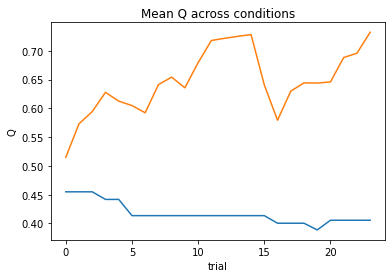

In [7]:
# use one subject (feel free to change)
behavior = subject_data[9] 

# guess for alpha and theta
params = [.12, 2.11] 

# specify subject data
choices = behavior.true_accuracy
outcomes = behavior.outcome
block = behavior.block 

# compute negative log likelihood given
# data and guessed parameters
subj_negll = Simple_1a1t(params, choices, outcomes, block, plot=True)

Now, let's put this into a for-loop to minimize the negative log likelihood across all subjects.

subject 01: alpha=0.91, theta=3.13; negLL=41.24; BIC=-73.34


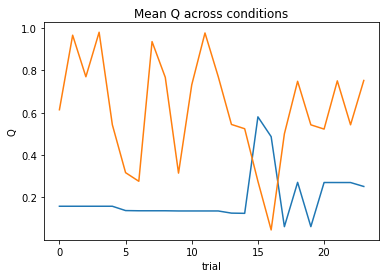

subject 02: alpha=0.03, theta=12.00; negLL=51.42; BIC=-93.71


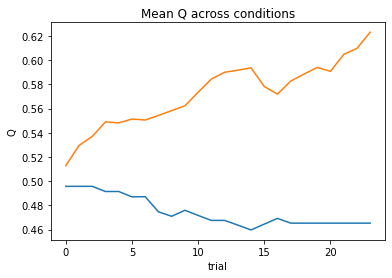

subject 03: alpha=0.06, theta=12.00; negLL=41.13; BIC=-73.13


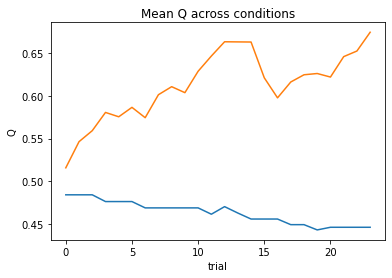

subject 04: alpha=0.00, theta=1.00; negLL=66.54; BIC=-123.96


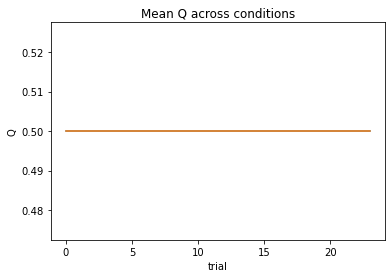

subject 05: alpha=0.23, theta=7.15; negLL=35.25; BIC=-61.37


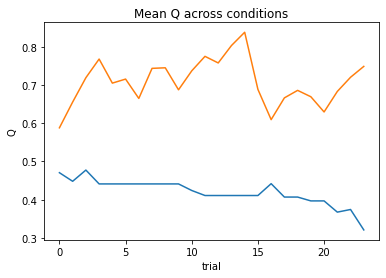

subject 06: alpha=0.44, theta=5.81; negLL=28.37; BIC=-47.61


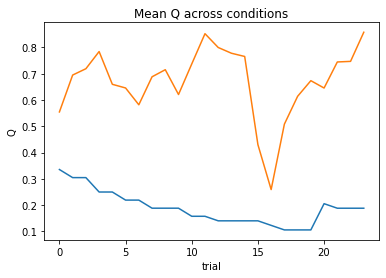

subject 07: alpha=0.13, theta=12.00; negLL=19.16; BIC=-29.18


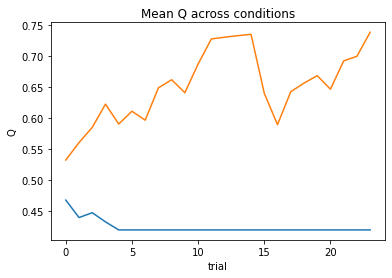

subject 08: alpha=0.16, theta=5.38; negLL=48.77; BIC=-88.42


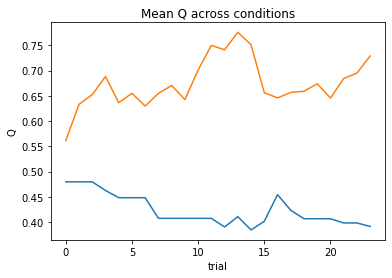

subject 09: alpha=0.31, theta=7.58; negLL=28.84; BIC=-48.54


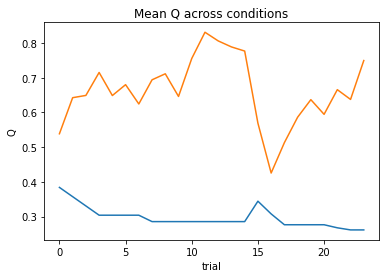

subject 10: alpha=0.31, theta=11.00; negLL=18.06; BIC=-27.00


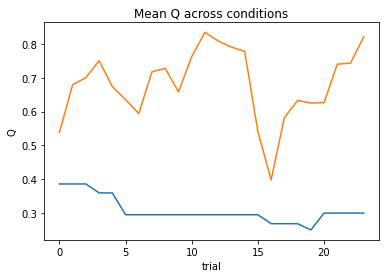

subject 11: alpha=0.25, theta=12.00; negLL=12.57; BIC=-16.00


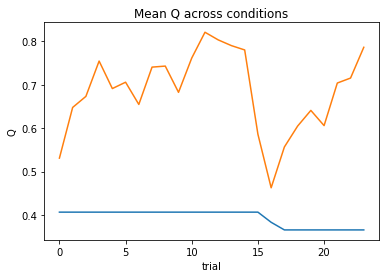

In [8]:
#initialize dataframe to store results
df1 = pd.DataFrame(index=range(11), columns=['alpha','theta','NLL'])

# initialize list of algorithms 
# (use one during class, but you can try a few others on your own)
algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
    bounds = ((0,1),(0,12))

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha
    for alpha_guess in np.linspace(0,1,3):
        for theta_guess in np.linspace(1,12,4):

            # guesses for alpha, theta will change on each loop
            init_guess = (alpha_guess, theta_guess)

            for algorithm in algorithms:

                # minimize neg LL
                result = minimize(Simple_1a1t,
                                  init_guess,
                                  (c, o, block),
                                  bounds=bounds,
                                  method=algorithm)

                # if current negLL is smaller than the last negLL,
                # then store current data
                if result.fun < res_nll and result.success:
                    res_nll = result.fun
                    param_fits = result.x

    # also, compute BIC
    BIC = -2 * res_nll + len(init_guess) * np.log(len(c))

    #store in dataframe
    df1.at[index, 'alpha'] = param_fits[0]
    df1.at[index, 'theta'] = param_fits[1]
    df1.at[index, 'NLL'] = res_nll
    df1.at[index, 'BIC'] = BIC

    # print/plot Q values for subject   
    print(fr'subject {index+1:02}: alpha={param_fits[0]:.2f}, theta={param_fits[1]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
    nll = Simple_1a1t(param_fits, c, o, block, plot=True)

At a quick glance at the **negative log likelihood** and **BIC** values, we can see that this model performs better for some subjects relative to others. Some subjects even perform so poorly that we can't estimate parameters for them. We can see this all at once in the `DataFrame` we created to store the outputs.

In [9]:
display(df1)

,alpha,theta,NLL,BIC
0,0.910384,3.125691,41.235016,-73.341337
1,0.034217,12.0,51.419038,-93.709379
2,0.063137,12.0,41.131208,-73.133719
3,0.0,1.0,66.542129,-123.955562
4,0.234915,7.149005,35.249369,-61.370042
5,0.438106,5.812433,28.370059,-47.611421
6,0.129681,12.0,19.155706,-29.182715
7,0.163722,5.379729,48.774263,-88.419830
8,0.30879,7.577297,28.83555,-48.542404
9,0.305454,11.001908,18.063611,-26.998525


<hr width=50%>

**Let's try a different model...**

Our task is very similar to the task used by [Lockwood et al. (2016)](https://doi.org/10.1073/pnas.1603198113). Think about how the authors modeled human social behavior in their task!

One variation included `learning rate` parameters (e.g., `alpha`) that indexed sensitivity to prediction errors for both (1) self (e.g., `alpha_self`) and (2) other (e.g., `alpha_other`). How about we try that for our data?

In [10]:
def Social_2a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self + 1 alpha_other + 1 theta
    '''
    Inputs:
        - params: list of 3 guesses (float) for each parameter (alpha_self, alpha_other, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_self, alpha_other, theta = params 
    
    # check inputs
    if np.isnan(alpha_self) or np.isnan(alpha_other) or np.isnan(theta): 
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c = np.array(choices)[cur_indices]
            r = np.array(outcomes)[cur_indices]

            # check if self vs social
            #    Note: this bulky if-statement
            #    is intentional to make it clear
            #    what we are doing
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    # don't update if nan 
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    
                    if 'self' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_self * delta
                    elif 'social' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_other * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

Now, let's put this into a for-loop to minimize the negative log likelihood across all subjects.

subject 01: alpha_self=0.76, alpha_other=1.00, theta=3.30; negLL=40.68; BIC=-67.67


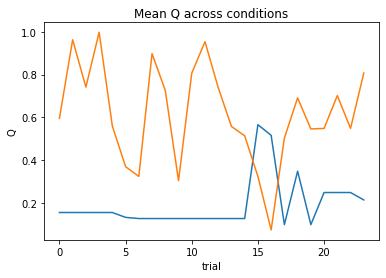

subject 02: alpha_self=0.08, alpha_other=0.02, theta=12.00; negLL=46.42; BIC=-79.14


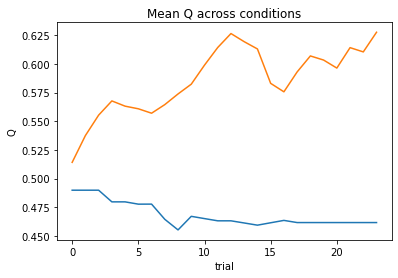

subject 03: alpha_self=0.11, alpha_other=0.04, theta=12.00; negLL=38.84; BIC=-64.00


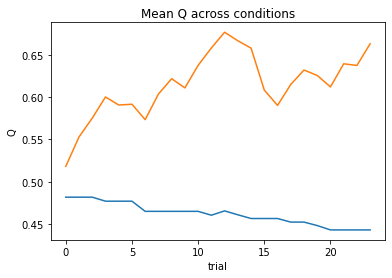

subject 04: alpha_self=0.00, alpha_other=0.00, theta=12.00; negLL=66.41; BIC=-119.12


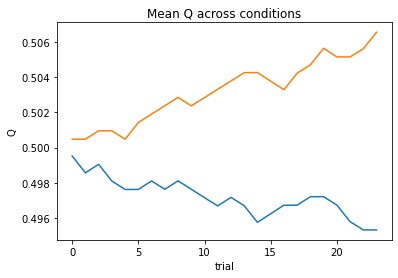

subject 05: alpha_self=0.26, alpha_other=0.18, theta=7.69; negLL=35.02; BIC=-56.34


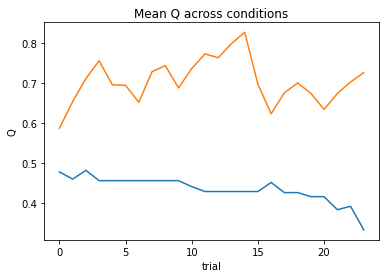

subject 06: alpha_self=0.30, alpha_other=0.65, theta=6.24; negLL=27.35; BIC=-41.00


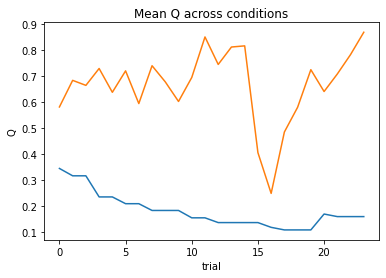

subject 07: alpha_self=0.14, alpha_other=0.12, theta=12.00; negLL=19.08; BIC=-24.46


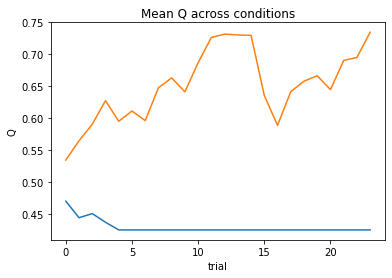

subject 08: alpha_self=0.16, alpha_other=0.69, theta=3.99; negLL=47.11; BIC=-80.52


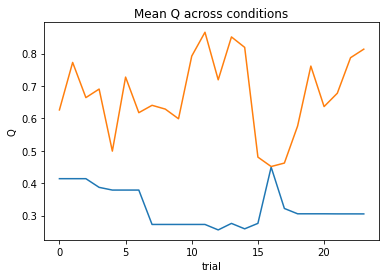

subject 09: alpha_self=0.42, alpha_other=0.24, theta=7.91; negLL=28.21; BIC=-42.73


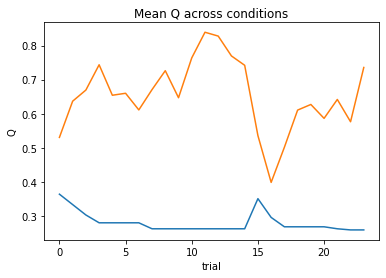

subject 10: alpha_self=0.29, alpha_other=0.80, theta=12.00; negLL=17.71; BIC=-21.73


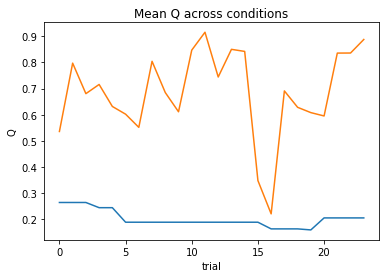

subject 11: alpha_self=0.33, alpha_other=0.20, theta=12.00; negLL=12.02; BIC=-10.35


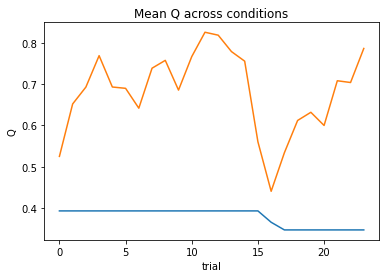

In [11]:
#initialize dataframe to store results
df2 = pd.DataFrame(index=range(11), columns=['alpha_self','alpha_other','theta','NLL'])

# initialize list of algorithms 
# (use one during class, but you can try a few others on your own)
algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

# loop through subjects
for index, behavior in enumerate(subject_data.values()):
    c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
    bounds = ((0,1),(0,1),(0,12))

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf

    # guess several different starting points for alpha
    for alpha_self_guess in np.linspace(0,1,3):
        for alpha_other_guess in np.linspace(0,1,3):
            for theta_guess in np.linspace(1,12,4):

                # guesses for alpha, theta will change on each loop
                init_guess = (alpha_self_guess, alpha_other_guess, theta_guess)

                for algorithm in algorithms:

                    # minimize neg LL
                    result = minimize(Social_2a1t,
                                      init_guess,
                                      (c, o, block),
                                      bounds=bounds,
                                      method=algorithm)

                    # if current negLL is smaller than the last negLL,
                    # then store current data
                    if result.fun < res_nll and result.success:
                        res_nll = result.fun
                        param_fits = result.x

    # also, compute BIC
    BIC = -2 * res_nll + len(init_guess) * np.log(len(c))

    #store in dataframe
    df2.at[index, 'alpha_self'] = param_fits[0]
    df2.at[index, 'alpha_other'] = param_fits[1]
    df2.at[index, 'theta'] = param_fits[2]
    df2.at[index, 'NLL'] = res_nll
    df2.at[index, 'BIC'] = BIC

    # print/plot Q values for subject   
    print(fr'subject {index+1:02}: alpha_self={param_fits[0]:.2f}, alpha_other={param_fits[1]:.2f}, theta={param_fits[2]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
    nll = Social_2a1t(param_fits, c, o, block, plot=True)

In [12]:
display(df2)

,alpha_self,alpha_other,theta,NLL,BIC
0,0.760689,1.0,3.295711,40.681883,-67.670721
1,0.081382,0.015783,12.0,46.417372,-79.141698
2,0.107811,0.037979,12.0,38.844495,-63.995945
3,0.0,0.003832,12.0,66.406572,-119.120098
4,0.260908,0.175293,7.693504,35.018243,-56.343442
5,0.296518,0.651074,6.241567,27.348106,-41.003168
6,0.139729,0.11758,12.0,19.077929,-24.462814
7,0.160885,0.688449,3.992985,47.106963,-80.520881
8,0.424338,0.242731,7.908342,28.212399,-42.731752
9,0.285959,0.801353,12.0,17.710507,-21.727969


What do we think? At a glance, do we think this model was better at characterizing the behavior? 

<hr>

### Fitting your own models!

Now, we will split into our groups (3-4 students per group) to brainstorm other plausible models and then collaboratively write code to fit the data to these new models!

Here are some hints/ideas:
* Think [Lockwood et al. (2016)](https://doi.org/10.1073/pnas.1603198113)! The authors had more than one `learning rate`. What else did they include in their best-fitting model? Why?
* What else is different about this task? Do participants always "play to win" like they do in [Lockwood et al. (2016)](https://doi.org/10.1073/pnas.1603198113)? What other conditions are there?

In [13]:
# Model 3(12 out of 30 points)
def Valence_2a1t(params, choices, outcomes, block):
    # 1 alpha_positive + 1 alpha_negative + 1 theta
    
    return negLL

In [14]:
# fit model here and store output in df3

In [15]:
# Model 4 (12 out of 30 points)
def Social_2a2t(params, choices, outcomes, block, plot=False):
    # 1 alpha + 1 beta_self + 1 beta_other + 1 theta
    
    return negLL

In [16]:
# fit model here and store output in df4

In [17]:
# Bonus Model 5 (not required for exercise)
def SocialValence_4a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self_pos + 1 alpha_self_neg +
    # 1 alpha_other_pos + 1 alpha_other_neg + 1 theta
    
    return negLL

In [18]:
# fit model here and store output in df5

<hr width="50%">

Now, we should have run 3-4 models that we can compare to assess which model might explain the data best. Remember we store the parameter fits in Pandas DataFrames: `df1`, `df2`, `df3`, `df4`, and maybe `df5` (if you completed the bonus).

Let's use this information to compute Bayesian Information Criterion ($BIC$) across subjects for each model. One way in which we can do so is by summing the negative log likelihoods across subjects for each model and using that value to compute a $BIC$ score. Then, we can plot each $BIC$ to assess model fits. Please do this below.

***Hints***
* to compute the sum of the negative likelihoods for the first model, you would use the command: `np.nansum(df1['NLL'].values)`.
* You can refer to [this page](https://shawnrhoads.github.io/gu-psyc-347/module-02-01_Nonlinear-Modeling.html#model-comparison) to review Bayesian Information Criterion ($BIC$), but note that tutorial used $MSE$ to compute the $BIC$. Here, we will use the negative log likelihood (like [in this tutorial](https://shawnrhoads.github.io/gu-psyc-347/module-03-01_Models-of-Learning.html#gradient-descent)). Therefore, we won't need to multiply by a $-1$! Also, remember to factor in the number of free parameters in each of your models!
* Remember we will have 4-5 $BIC$ values by the end of this tutorial.

```
# Compute BIC for each Model and Plot (6 out of 30 points)
def calculate_bic(n, nll, num_params):
    
    return bic

def plot_bic(list_of_dfs, list_of_num_params, df_names):
    # 96 trials across 11 subjects
    all_num_trials = 96 * 11

    #init list to input bic values
    bic_list = []

    all_mods = ...
    all_num_params = ...

    # get integrated BIC for each model
    for mod, num_params in zip(all_mods, all_num_params):
        bic_temp = calculate_bic(n=..., nll=..., num_params=...)
        bic_list.append(bic_temp)

    #plot these values:
    plt.bar(range(0,len(all_mods)), bic_list)
    plt.xlabel("Model")
    plt.ylabel("BIC Score")
    plt.title("BIC Scores for Different Models")

    plt.xticks(range(0,len(all_mods)), df_names)
    plt.show()

list_of_dfs = [df1, df2, df3, df4, df5]
df_names = ['df1', 'df2', 'df3', 'df4', 'df5']
list_of_num_params = [2, 3, 3, 4, 5]
plot_bic(list_of_dfs, list_of_num_params, df_names)
```

Which of these models fit the data best? Think about whether there be others that could do better!

<hr>

In [ ]:
# Finally, please convert this cell to a Markdown cell.

# Create a Heading named "Notebook Feedback," then delete this text 
# and provide 1-2 sentences about your experience with this 
# Jupyter Notebook (e.g., Did you enjoy the exercises? Were 
# they too easy/difficult? Would you have like to see 
# anything different? Were you able to apply some skills we learned during
# class? Anything still confusing?). Finally, please rate your experience
# from (0) "did not enjoy at all" to (10) "enjoyed a great deal." Only your
# instructor will see these responses. 

In you are working on Google Colab, go to **File > Download > Download .ipynb** to download your work. Then, save the file as **"Lastname_Exercise04.ipynb"** and submit on Canvas.

## Solutions
See the solutions at the following links:
- <a href="https://shawnrhoads.github.io/gu-psyc-347/solutions/module-04-01_Prosocial-RL-Exercises-Solutions.html" target="_blank">Jupyter Book</a> 
- <a href="https://colab.research.google.com/github/shawnrhoads/gu-psyc-347/blob/master/docs/solutions/module-04-01_Prosocial-RL-Exercises-Solutions.ipynb" target="_blank">Google Colaboratory</a> 